# **Sentiment Analysis and Summarization of Product Reviews**

## **Introduction**
With the exponential growth of e-commerce, understanding customer sentiment from product reviews has become a critical task. Analyzing sentiments not only helps businesses improve their products but also enables customers to make informed decisions. This project focuses on performing sentiment analysis on product reviews from the **Cell Phones and Accessories** category. Using advanced natural language processing (NLP) techniques and pre-trained transformer models, we aim to classify sentiments and summarize customer feedback effectively.

## **Objective**
The main objectives of this project are:
1. **Sentiment Classification**:
    - Categorize customer reviews into positive and negative sentiments.
    - Compare results from traditional methods like VADER with modern transformer-based models like RoBERTa.
2. **Data Visualization**:
    - Visualize sentiment distribution and correlations with overall ratings.
3. **Summarization**:
    - Summarize positive and negative reviews using a pre-trained summarization model.
4. **Custom Model Training**:
    - Fine-tune a transformer model (RoBERTa) for sentiment classification on this dataset.
5. **Deployable Model**:
    - Save the fine-tuned model for future use in real-world applications.

## **Workflow**
### 1. Data Loading and Preprocessing
### 2. Exploratory Data Analysis (EDA)
### 3. Sentiment Analysis (VADER and RoBERTa)
### 4. Summarization
### 5. Custom Model Training
### 6. Save and Deploy the Model

## **Tools and Libraries**
- **Data Analysis and Visualization**:
  - `pandas`, `matplotlib`, `seaborn`
- **Natural Language Processing**:
  - `nltk` (VADER sentiment analysis)
  - `transformers` (RoBERTa, BART summarization)
- **Training and Deployment**:
  - Hugging Face `Trainer` API for model fine-tuning
  - `datasets` library for data preprocessing

## **Expected Outcome**
- Trained sentiment analysis model capable of classifying customer reviews.
- Visual insights into customer feedback with concise summaries.
- Deployable fine-tuned sentiment analysis model.



# **1. Libraries and Dependencies**

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from datasets import Dataset
from scipy.special import softmax
plt.style.use('ggplot')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import pipeline

import shutil

nltk.download('punkt_tab')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# **2. Dataset Loading and Preprocessing**

In [24]:
with open('/content/Cell_Phones_and_Accessories_5.json', 'r') as f:
    data = f.read()

try:
    dataset = pd.read_json(data, lines=True)
except ValueError:
    last_bracket = data.rfind('}')
    if last_bracket != -1:
        cleaned_data = data[: last_bracket + 1]
        dataset = pd.read_json(cleaned_data, lines=True)
    else:
        raise

print(dataset.head())

<ipython-input-24-ba14f3f5e312>:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  dataset = pd.read_json(data, lines=True)


       reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...        4   
1  These stickers work like the review says they ...        5   
2  These are awesome and make my phone look so st...        5   
3  Item arrived in great time and was in perfect ...        4   
4  awesome! stays on, and looks great. can be use...        5   

                                     summary  unixReviewTime   reviewTime  
0                                 Looks Good      1400630400  05 21, 2014  
1                      Really great product.      1389657600  01 14, 2014  
2                         

In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194439 entries, 0 to 194438
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      194439 non-null  object
 1   asin            194439 non-null  object
 2   reviewerName    190920 non-null  object
 3   helpful         194439 non-null  object
 4   reviewText      194439 non-null  object
 5   overall         194439 non-null  int64 
 6   summary         194439 non-null  object
 7   unixReviewTime  194439 non-null  int64 
 8   reviewTime      194439 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.4+ MB


In [26]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [27]:
dataset['reviewText'][0]

"They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again"

In [28]:
print(dataset.shape)
df = dataset.head(1000)


(194439, 9)


In [29]:
df.shape

(1000, 9)

# **3. Exploratory Data Analysis (EDA)**

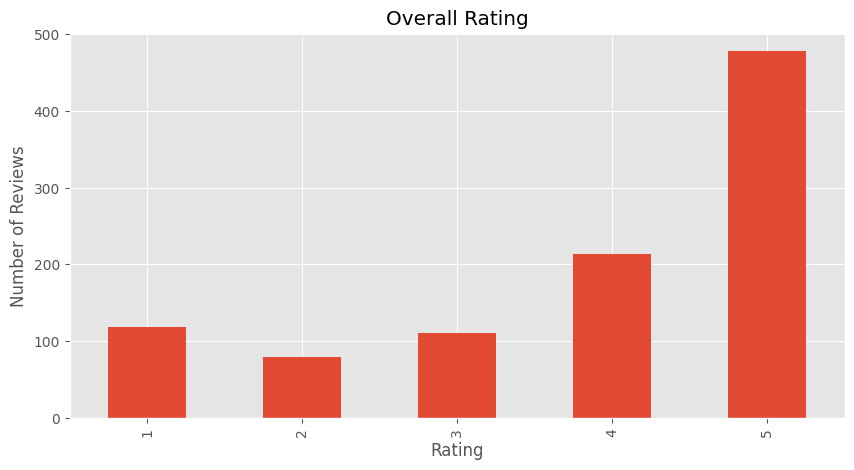

In [30]:
ax = df['overall'].value_counts().sort_index()\
.plot(kind='bar', title='Overall Rating',
      figsize=(10,5))

ax.set_xlabel('Rating')
ax.set_ylabel('Number of Reviews')
plt.show()



# **4. Basic Natural Language Processing (NLP) with NLTK**


In [31]:
example = df['reviewText'][0]
print(example)

They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again


In [32]:

tokens = nltk.word_tokenize(example)
tokens[:10]

['They', 'look', 'good', 'and', 'stick', 'good', '!', 'I', 'just', 'do']

In [33]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('They', 'PRP'),
 ('look', 'VBP'),
 ('good', 'JJ'),
 ('and', 'CC'),
 ('stick', 'JJ'),
 ('good', 'JJ'),
 ('!', '.'),
 ('I', 'PRP'),
 ('just', 'RB'),
 ('do', 'VBP')]

In [34]:

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  They/PRP
  look/VBP
  good/JJ
  and/CC
  stick/JJ
  good/JJ
  !/.
  I/PRP
  just/RB
  do/VBP
  n't/RB
  like/VB
  the/DT
  rounded/JJ
  shape/NN
  because/IN
  I/PRP
  was/VBD
  always/RB
  bumping/VBG
  it/PRP
  and/CC
  (PERSON Siri/NNP)
  kept/VBD
  popping/VBG
  up/RP
  and/CC
  it/PRP
  was/VBD
  irritating/VBG
  ./.
  I/PRP
  just/RB
  wo/MD
  n't/RB
  buy/VB
  a/DT
  product/NN
  like/IN
  this/DT
  again/RB)



# **5. Sentiment Analysis Using VADER**

In [35]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [36]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [37]:
sia.polarity_scores(example)

{'neg': 0.182, 'neu': 0.678, 'pos': 0.14, 'compound': -0.1808}

In [38]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows()):
  text = row['reviewText']
  myid = row['reviewerID']
  res[myid] = sia.polarity_scores(text)

0it [00:00, ?it/s]

In [39]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'reviewerID'})
vaders = vaders.merge(df, how='left')

In [40]:
vaders.head()

,reviewerID,neg,neu,pos,compound,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,0.182,0.678,0.140,-0.1808,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,0.000,0.624,0.376,0.9403,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,0.000,0.762,0.238,0.8852,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,0.000,0.686,0.314,0.9625,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,0.000,0.643,0.357,0.9020,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


# Visualizations for VADER

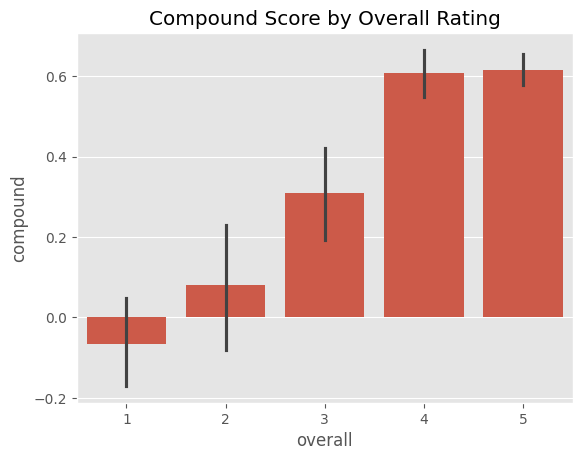

In [41]:
ax = sns.barplot(data=vaders, x='overall', y='compound')
ax.set_title('Compound Score by Overall Rating')
plt.show()

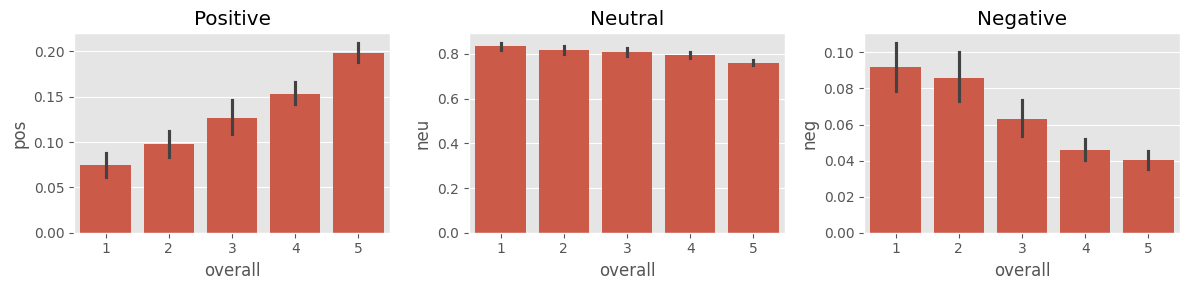

In [42]:
fig,axs = plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders, x='overall', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='overall', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


# **6. Sentiment Analysis Using RoBERTa**

In [43]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [44]:
print(example)
sia.polarity_scores(example)

They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again


{'neg': 0.182, 'neu': 0.678, 'pos': 0.14, 'compound': -0.1808}

In [45]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9059413, 'roberta_neu': 0.078195974, 'roberta_pos': 0.015862765}


In [46]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
      'roberta_neg' : scores[0],
      'roberta_neu' : scores[1],
      'roberta_pos' : scores[2]
  }
  return scores_dict

In [47]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  try:
    text = row['reviewText']
    myid = row['reviewerID']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f'vader_{key}'] = value

    roberta_result = polarity_scores_roberta(text)
    both = {**vader_result_rename, **roberta_result}
    res[myid] = both

  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id A3H3SG8XIXVKXZ
Broke for id A2PRIQ2EA5GYML
Broke for id A3NOBH42C7UI5M
Broke for id A6FIAB28IS79
Broke for id A14EF1PPKMSEPU
Broke for id A18MBO1U4DPY20
Broke for id A1W5N8OT55A9Y3
Broke for id A680RUE1FDO8B
Broke for id A3VAROHXBXV0I2
Broke for id ALUTHT4U058KZ
Broke for id A1N03V52IRZ5PR
Broke for id ANF5BP1SD3Z3O
Broke for id AVPNQUVZWMDSX
Broke for id AEC0BTMNIZZSL
Broke for id A360VP3RBMJFDL
Broke for id AVQVQKO2PAQVF
Broke for id A1N03V52IRZ5PR
Broke for id A2L4XGVPR42KHL
Broke for id A3ONE2VJCDI5GZ
Broke for id A12EVK82QUTSA6
Broke for id A3QYIBMXQVLVE7
Broke for id A2E2I580OO3HET
Broke for id A3AUR4JFEJNXDY
Broke for id A39KJOCZGCM8P1
Broke for id A952LJOXPLTVL
Broke for id A3JMO0ET6611HV
Broke for id AVK9BSXJJ51I8
Broke for id A35IX2GE0VC0JP
Broke for id A3LSLLR3OAJI7Y
Broke for id A35IX2GE0VC0JP
Broke for id A1XDM756QE06E4


In [48]:
vader_result

{'neg': 0.122, 'neu': 0.769, 'pos': 0.108, 'compound': -0.2031}

In [49]:
roberta_result

{'roberta_neg': 0.55041283,
 'roberta_neu': 0.31370857,
 'roberta_pos': 0.13587858}

In [50]:
both

{'vader_neg': 0.122,
 'vader_neu': 0.769,
 'vader_pos': 0.108,
 'vader_compound': -0.2031,
 'roberta_neg': 0.55041283,
 'roberta_neu': 0.31370857,
 'roberta_pos': 0.13587858}

In [51]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'reviewerID'})
results_df = results_df.merge(df, how='left')

In [52]:
results_df.head()

,reviewerID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,0.182,0.678,0.140,-0.1808,0.905941,0.078196,0.015863,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,0.000,0.624,0.376,0.9403,0.001159,0.012350,0.986490,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,0.000,0.762,0.238,0.8852,0.002077,0.005742,0.992181,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,0.000,0.686,0.314,0.9625,0.029853,0.141378,0.828769,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,0.000,0.643,0.357,0.9020,0.001848,0.023521,0.974630,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


# Pairplot Comparison

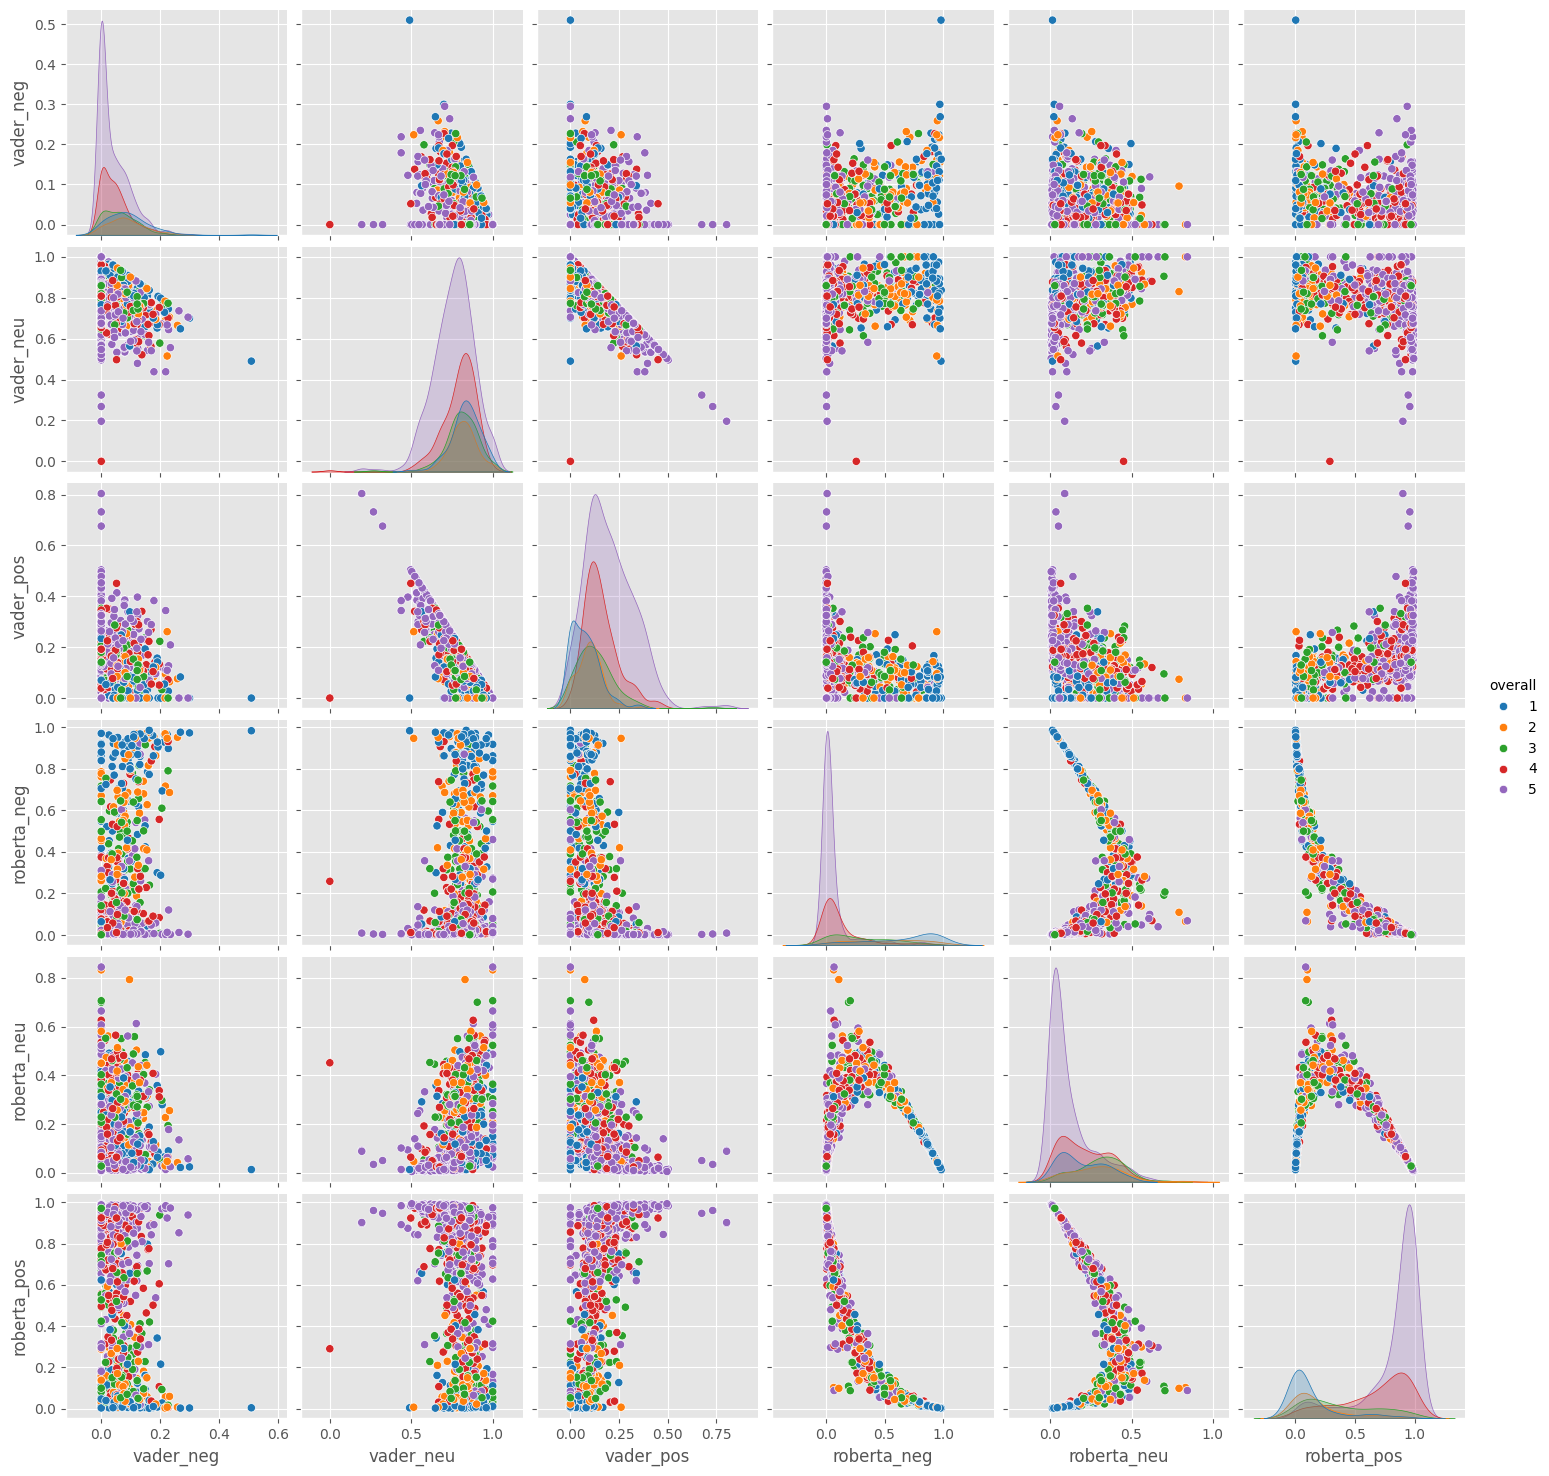

In [53]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu','roberta_pos'],
             hue='overall',
             palette='tab10')
plt.show()

## Review Examples

In [54]:
results_df.query('overall==1').sort_values('roberta_pos', ascending=False)['reviewText'].values[0]

"This charger doesn't charge the battery of my Samsung Galaxy S2 (i9100) properly.When I connect it to my S2, the screen gets frozen and the cell behaves in a unusual (abnormal) way."

In [55]:
results_df.query('overall==5').sort_values('roberta_neg', ascending=False)['reviewText'].values[0]

'DO NOT USE THIS THOUGH IF YOUR PHONE IS STILL UNDER WARRANTY CUZ US CELLULAR SAID IT VOIDED MY WARRANTY, BUT US CELLULAR IS THE WORST CELL PHONE CARRIER OUT THERE. I SHOULD NOT HAVE EVEN NEEDED THIS WITH A BRAND NEW SAMSUNG GALAXY S3 BUT I DID...THE INSTRUCTIONS COULD HAVE BEEN A LITTLE BETTER IS MY ONLY COMPLAINT'

In [56]:
results_df.query('overall==1').sort_values('vader_pos', ascending=False)['reviewText'].values[0]

"This charger doesn't charge the battery of my Samsung Galaxy S2 (i9100) properly.When I connect it to my S2, the screen gets frozen and the cell behaves in a unusual (abnormal) way."

In [57]:
results_df.query('overall==5').sort_values('vader_neg', ascending=False)['reviewText'].values[0]

'Product arrived on time. I charged the battery fully and it works as intended with no problems in my phone.'

# Positive and Negative Reviews

In [58]:
df['label'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)

<ipython-input-58-f4ef93557295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)


# **7. Training a Custom Sentiment Model**

In [59]:

data = Dataset.from_pandas(df[['reviewText', 'label']])


In [60]:
def tokenize_function(examples):
    return tokenizer(examples["reviewText"], padding="max_length", truncation=True, max_length=512)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [61]:
tokenized_dataset = tokenized_data.train_test_split(test_size=0.2)

train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['test']

In [62]:


# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-63-88d13786757c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.285457
2,No log,0.313984
3,No log,0.330198


TrainOutput(global_step=150, training_loss=0.2956915791829427, metrics={'train_runtime': 316.6717, 'train_samples_per_second': 7.579, 'train_steps_per_second': 0.474, 'total_flos': 631472202547200.0, 'train_loss': 0.2956915791829427, 'epoch': 3.0})

# Save Model

In [64]:
# Save the model
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

# Evaluate on validation set
results = trainer.evaluate()
print(results)

{'eval_loss': 0.33019763231277466, 'eval_runtime': 5.5623, 'eval_samples_per_second': 35.956, 'eval_steps_per_second': 2.337, 'epoch': 3.0}


In [65]:
# Load the trained pipeline
sentiment_pipeline = pipeline("text-classification", model='./sentiment_model', tokenizer='./sentiment_model')

# Predict sentiment for new reviews
new_reviews = ["This product is amazing!", "Not worth the money."]
predictions = sentiment_pipeline(new_reviews)

print(predictions)

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9765310883522034}, {'label': 'LABEL_0', 'score': 0.9399478435516357}]


In [66]:
reviews = [
    "The sound quality is superb, with excellent noise cancellation and a noticeable improvement over the first generation. Totally worth it!",  # Positive
    "Love the fit and comfort of these AirPods. They stay secure during workouts and offer incredible audio clarity.",  # Positive
    "Battery life has been great so far, and the quick charging case is a lifesaver. A premium product, no doubt.",  # Positive
    "Transparency mode is fantastic for commuting—lets me stay aware of my surroundings without removing the earbuds.",  # Positive
    "The touch controls are intuitive and a welcome improvement, making it easy to adjust volume or skip tracks.",  # Positive
    "Connectivity is seamless with my iPhone and MacBook, but I wish it supported better compatibility with Android devices.",  # Negative
    "The sound is crisp, but I noticed occasional connectivity drops, which was a bit frustrating for the price.",  # Negative
    "Build quality feels solid and durable, but the case scratches easily. A protective cover is a must!",  # Negative
    "Spatial audio blew me away. It feels like I'm in the middle of a live concert!",  # Positive
    "Pricey, but the features like Find My integration and MagSafe charging make it worth the investment.",  # Positive
    "Noise cancellation is good, but I expected a bit more given all the hype. Still a solid choice overall.",  # Negative
    "Customizable ear tips ensure a perfect fit, and they’re great for extended listening sessions without discomfort.",  # Positive
    "The sound balance is excellent, with deep bass and clear highs. Perfect for all genres of music.",  # Positive
    "A bit disappointed with the microphone quality during calls—it picks up a lot of background noise.",  # Negative
    "These are my go-to earbuds for everyday use. Lightweight, premium sound, and reliable performance.",  # Positive
    "The noise cancellation isn't as effective in extremely loud environments. It struggles with consistent blocking.",  # Negative
    "After a few months of use, the battery life has noticeably degraded, which is disappointing for the price.",  # Negative
    "The earbuds are uncomfortable for long use, and the ear tips don't seem to fit me well.",  # Negative
    "While the sound quality is great, I find them too expensive compared to similar products on the market.",  # Negative
    "Excellent integration with Apple devices, making the user experience seamless and enjoyable.",  # Positive
]

In [67]:
predictions_review = sentiment_pipeline(reviews)
print(predictions_review)

[{'label': 'LABEL_1', 'score': 0.992228090763092}, {'label': 'LABEL_1', 'score': 0.9932193160057068}, {'label': 'LABEL_1', 'score': 0.9928836822509766}, {'label': 'LABEL_1', 'score': 0.9939113855361938}, {'label': 'LABEL_1', 'score': 0.9944356679916382}, {'label': 'LABEL_1', 'score': 0.9871709942817688}, {'label': 'LABEL_0', 'score': 0.9639450311660767}, {'label': 'LABEL_1', 'score': 0.9440791010856628}, {'label': 'LABEL_1', 'score': 0.9772608876228333}, {'label': 'LABEL_1', 'score': 0.9926927089691162}, {'label': 'LABEL_1', 'score': 0.9666017889976501}, {'label': 'LABEL_1', 'score': 0.9940263032913208}, {'label': 'LABEL_1', 'score': 0.9923270344734192}, {'label': 'LABEL_0', 'score': 0.985663115978241}, {'label': 'LABEL_1', 'score': 0.9948947429656982}, {'label': 'LABEL_0', 'score': 0.9800392985343933}, {'label': 'LABEL_0', 'score': 0.978816032409668}, {'label': 'LABEL_0', 'score': 0.9888691902160645}, {'label': 'LABEL_0', 'score': 0.9292938113212585}, {'label': 'LABEL_1', 'score': 0.9

In [68]:
predictions_review[0]['label']

'LABEL_1'

In [69]:
label_list = [pred['label'] for pred in predictions_review]

In [70]:
label_list

['LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_0',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_1',
 'LABEL_0',
 'LABEL_1',
 'LABEL_0',
 'LABEL_0',
 'LABEL_0',
 'LABEL_0',
 'LABEL_1']

In [71]:
df_pred = pd.DataFrame({'review': reviews, 'label': label_list})
print(df_pred)

                                               review    label
0   The sound quality is superb, with excellent no...  LABEL_1
1   Love the fit and comfort of these AirPods. The...  LABEL_1
2   Battery life has been great so far, and the qu...  LABEL_1
3   Transparency mode is fantastic for commuting—l...  LABEL_1
4   The touch controls are intuitive and a welcome...  LABEL_1
5   Connectivity is seamless with my iPhone and Ma...  LABEL_1
6   The sound is crisp, but I noticed occasional c...  LABEL_0
7   Build quality feels solid and durable, but the...  LABEL_1
8   Spatial audio blew me away. It feels like I'm ...  LABEL_1
9   Pricey, but the features like Find My integrat...  LABEL_1
10  Noise cancellation is good, but I expected a b...  LABEL_1
11  Customizable ear tips ensure a perfect fit, an...  LABEL_1
12  The sound balance is excellent, with deep bass...  LABEL_1
13  A bit disappointed with the microphone quality...  LABEL_0
14  These are my go-to earbuds for everyday use. L...  

# Positive and Negative Reviews

In [72]:
pred_pos = df_pred[df_pred['label'] == 'LABEL_1']
pred_neg = df_pred[df_pred['label'] == 'LABEL_0']

In [73]:

print(pred_pos)
print(pred_neg)

                                               review    label
0   The sound quality is superb, with excellent no...  LABEL_1
1   Love the fit and comfort of these AirPods. The...  LABEL_1
2   Battery life has been great so far, and the qu...  LABEL_1
3   Transparency mode is fantastic for commuting—l...  LABEL_1
4   The touch controls are intuitive and a welcome...  LABEL_1
5   Connectivity is seamless with my iPhone and Ma...  LABEL_1
7   Build quality feels solid and durable, but the...  LABEL_1
8   Spatial audio blew me away. It feels like I'm ...  LABEL_1
9   Pricey, but the features like Find My integrat...  LABEL_1
10  Noise cancellation is good, but I expected a b...  LABEL_1
11  Customizable ear tips ensure a perfect fit, an...  LABEL_1
12  The sound balance is excellent, with deep bass...  LABEL_1
14  These are my go-to earbuds for everyday use. L...  LABEL_1
19  Excellent integration with Apple devices, maki...  LABEL_1
                                               review  

In [74]:
pred_pos = pd.DataFrame(pred_pos)
pred_neg = pd.DataFrame(pred_neg)

In [75]:
pred_pos

,review,label
0,"The sound quality is superb, with excellent no...",LABEL_1
1,Love the fit and comfort of these AirPods. The...,LABEL_1
2,"Battery life has been great so far, and the qu...",LABEL_1
3,Transparency mode is fantastic for commuting—l...,LABEL_1
4,The touch controls are intuitive and a welcome...,LABEL_1
5,Connectivity is seamless with my iPhone and Ma...,LABEL_1
7,"Build quality feels solid and durable, but the...",LABEL_1
8,Spatial audio blew me away. It feels like I'm ...,LABEL_1
9,"Pricey, but the features like Find My integrat...",LABEL_1
10,"Noise cancellation is good, but I expected a b...",LABEL_1



# **8. Sentiment Summarization**

In [76]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [77]:
pred_pos['review'].tolist()

['The sound quality is superb, with excellent noise cancellation and a noticeable improvement over the first generation. Totally worth it!',
 'Love the fit and comfort of these AirPods. They stay secure during workouts and offer incredible audio clarity.',
 'Battery life has been great so far, and the quick charging case is a lifesaver. A premium product, no doubt.',
 'Transparency mode is fantastic for commuting—lets me stay aware of my surroundings without removing the earbuds.',
 'The touch controls are intuitive and a welcome improvement, making it easy to adjust volume or skip tracks.',
 'Connectivity is seamless with my iPhone and MacBook, but I wish it supported better compatibility with Android devices.',
 'Build quality feels solid and durable, but the case scratches easily. A protective cover is a must!',
 "Spatial audio blew me away. It feels like I'm in the middle of a live concert!",
 'Pricey, but the features like Find My integration and MagSafe charging make it worth the

In [78]:
def summarize_reviews(reviews, summarizer, max_length=50, min_length=20):
    # Combine all reviews into a single string
    combined_text = " ".join(reviews)

    # Generate the summary
    summary = summarizer(
        combined_text,
        max_length=max_length,
        min_length=min_length,
        do_sample=False
    )
    return summary[0]['summary_text']

# Summarize positive reviews
positive_summary = summarize_reviews(pred_pos['review'].tolist(), summarizer)

# Summarize negative reviews
negative_summary = summarize_reviews(pred_neg['review'].tolist(), summarizer)

# Display the summaries
print("Positive Reviews Summary:")
print(positive_summary)

print("\nNegative Reviews Summary:")
print(negative_summary)

Positive Reviews Summary:
Love the fit and comfort of these AirPods. They stay secure during workouts and offer incredible audio clarity. Transparency mode is fantastic for commuting. Connectivity is seamless with my iPhone and MacBook, but I wish it supported better compatibility with

Negative Reviews Summary:
The sound is crisp, but I noticed occasional connectivity drops. The noise cancellation isn't as effective in extremely loud environments. The earbuds are uncomfortable for long use, and the ear tips don't seem to fit me well.



# **9. Zipping the Model**

In [79]:
# Path to the folder or file to be zipped
source_path = '/content/sentiment_model'  # Replace with your folder or file path

# Path for the output zip file
output_path = '/content/sentiment_model.zip'

# Create a zip file
shutil.make_archive(output_path.replace('.zip', ''), 'zip', source_path)

print(f"Zipped file created at {output_path}")

Zipped file created at /content/sentiment_model.zip
